In [71]:
# ライブラリの皆さん
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import time
import seaborn as sns
%matplotlib inline

In [35]:
# メソッドの皆さん
def count_columns(gzip_filename):
    chunks = pd.read_csv(gzip_filename, compression="gzip", index_col=0, chunksize=1, dtype=np.float32)
    for chunk in chunks:
        return len(chunk.columns)


def general_df(gz_file):
    return pd.read_csv(gz_file,
                       compression="gzip",
                       index_col=0,
                       dtype=np.float32)


def sampled_data_set(train_files):
    dfs = []
    for train_file in train_files:
        print(train_file)
        df = general_df(train_file)
        dfs.append(df)
    return pd.concat(dfs, axis=1)


def limited_cols_df_values(gz_file, use_cols):
    return pd.read_csv(gz_file, index_col=0, dtype=np.float32, usecols=use_cols).values


def use_cols_list(train_files, indices):
    count_list = []
    for train_file in train_files:
        count_list.append(count_columns(train_file))
    count_list.append(100000)

    cols_list = []
    cur = 0
    for i in range(0, len(count_list) - 1):
        counts = count_list[i]
        l = cur
        cur += counts
        r = cur
        cols = np.concatenate([[0], indices[np.where((l <= indices) & (indices < r))] + 1 - l])
        cols_list.append(cols)
    return cols_list


def entire_data_set(train_files, cols_list):
    values = []
    for train_file, cols in zip(train_files, cols_list):
        print(train_file, cols)
        value = pd.read_csv(train_file,
                            index_col=0,
                            dtype=np.float32,
                            usecols=cols).values
        values.append(value)
    return np.concatenate(values, axis=1)

In [62]:
# 入力ファイルの皆さん
INPUTS = [
    "../output/reduced_train_date_normalized.csv.gz",
    "../output/train_categorical_L3_S32_F3854.csv.gz",
    "../output/reduced_train_numeric.csv.gz",
    "../output/date_diff_train.csv.gz"
]

TESTS = [
    "../output/reduced_test_date_normalized.csv.gz",
    "../output/test_categorical_L3_S32_F3854.csv.gz",
    "../output/reduced_test_numeric.csv.gz",
    "../output/date_diff_test.csv.gz"
]

RESPONSE = "../output/train_response.csv.gz"

In [36]:
# 全入力データを読み込み
X = sampled_data_set(INPUTS)
y = general_df(RESPONSE).loc[X.index].values.ravel()
X = X.values

../output/reduced_train_date_normalized.csv.gz
../output/train_categorical_L3_S32_F3854.csv.gz
../output/reduced_train_numeric.csv.gz
../output/date_diff_train.csv.gz


In [37]:
# XGBoost の時間だめう！
clf = XGBClassifier(base_score=0.005)
clf.fit(X, y)

XGBClassifier(base_score=0.005, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [55]:
# とりあえず抽出
plt.hist(clf.feature_importances_[clf.feature_importances_>0])
important_indices = np.where(clf.feature_importances_ > 0.005)[0]
print(important_indices)

[ 124  134  135  136  143  161  172  179  276  362  481  482  483  499  500
  503  522  554  843  844  849  850  852  864  893  894  897  913  948  954
  980  988  990  993  998 1012 1016 1034 1045 1046 1047 1130 1131 1132]


In [ ]:
# 入力データを削減
cols_list = use_cols_list(INPUTS, important_indices)
X = entire_data_set(INPUTS, cols_list)
y = general_df(RESPONSE).values.ravel()

../output/reduced_train_date_normalized.csv.gz [  0 125 135 136 137 144]
../output/train_categorical_L3_S32_F3854.csv.gz [0 1]
../output/reduced_train_numeric.csv.gz [  0  11  18 115 201 320 321 322 338 339 342 361 393 682 683 688 689 691
 703 732 733 736 752 787 793 819 827 829 832 837 851 855 873 884 885 886]


In [ ]:
# 予測して Cross Validation
clf = XGBClassifier(max_depth=5, base_score=0.005)
cv = StratifiedKFold(y, n_folds=3)
predictions = np.ones(y.shape[0])
for i, (train, test) in enumerate(cv):
    predictions[test] = clf.fit(X[train], y[train]).predict_proba(X[test])[:, 1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y[test], predictions[test])))
print(roc_auc_score(y, predictions))

In [ ]:
# MCC 最適化
thresholds = np.linspace(0.01, 0.99, 200)
mcc = np.array([matthews_corrcoef(y, predictions > thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [63]:
# テストデータ読み込み
X = entire_data_set(TESTS, cols_list)

../output/reduced_test_date_normalized.csv.gz [  0 125 135 136 137 144]
../output/test_categorical_L3_S32_F3854.csv.gz [0 1]
../output/reduced_test_numeric.csv.gz [  0  11  18 115 201 320 321 322 338 339 342 361 393 682 683 688 689 691
 703 732 733 736 752 787 793 819 827 829 832 837 851 855 873 884 885 886]
../output/date_diff_test.csv.gz [0 1 2 3]


In [64]:
# 0 or 1 に正規化
predictions = (clf.predict_proba(X)[:, 1] > best_threshold).astype(np.int8)

In [65]:
# 提出データを生成
sub = pd.read_csv("../input/sample_submission.csv", index_col=0)
sub["Response"] = predictions
sub.to_csv("submission.csv.gz", compression="gzip")

(array([ 99.75864796,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.

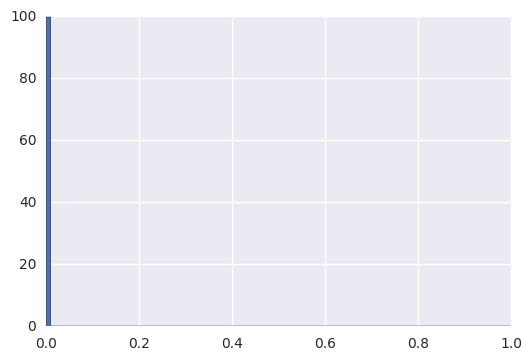

In [75]:
plt.hist(predictions, bins=100, normed=True)